Enter a dataset name from torchvision:  CIFAR10
Enter batch size:  32


Files already downloaded and verified
Successfully loaded CIFAR10 train dataset.
Files already downloaded and verified
Successfully loaded CIFAR10 test dataset.
Loaded a batch of size: 32


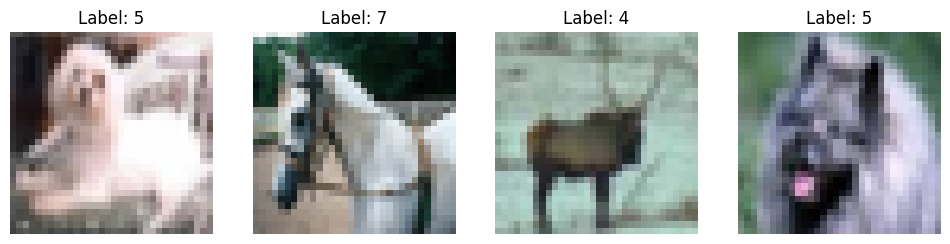

Enter a model name from torchvision:  resnet18


Successfully loaded resnet18 model.
Model resnet18 is ready to be used.


Enter the number of epochs:  2
Enter the learning rate:  0.01
Enable verbose output? (yes/no):  yes


Using device: cuda


Epoch 1/2, Loss: 1.8935


Epoch 2/2, Loss: 1.3033


Test Loss: 1.3584, Test Accuracy: 52.17%


In [27]:
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.data
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch
import difflib
import inspect
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Dynamically get a list of all available datasets in torchvision
def get_available_datasets():
    dataset_classes = []
    for name, obj in inspect.getmembers(datasets):
        if inspect.isclass(obj) and issubclass(obj, torch.utils.data.Dataset):
            dataset_classes.append(name)
    return dataset_classes

# Dynamically get a list of all available models in torchvision
def get_available_models():
    model_classes = []
    for name, obj in inspect.getmembers(models):
        if inspect.isfunction(obj):
            model_classes.append(name)
    return model_classes

available_datasets = get_available_datasets()
available_models = get_available_models()

# Define a set of transformations, including converting images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Function to get dataset with robust error handling
def get_dataset(dataset_name, root='./data', batch_size=4, shuffle=True, num_workers=2, train=True):
    try:
        if dataset_name in available_datasets:
            dataset_class = getattr(datasets, dataset_name)
            dataset_instance = dataset_class(root=root, download=True, train=train, transform=transform)
            data_loader = torch.utils.data.DataLoader(dataset_instance, 
                                                      batch_size=batch_size, 
                                                      shuffle=shuffle, 
                                                      num_workers=num_workers)
            print(f"Successfully loaded {dataset_name} {'train' if train else 'test'} dataset.")
            return data_loader
        else:
            close_matches = difflib.get_close_matches(dataset_name, available_datasets, n=3)
            if close_matches:
                print(f"Dataset '{dataset_name}' not found. Did you mean one of these?")
                for match in close_matches:
                    print(f"  - {match}")
                selected_suggestion = input(f"Would you like to load the dataset '{close_matches[0]}'? (yes/no): ").lower()
                if selected_suggestion == 'yes':
                    return get_dataset(close_matches[0], root, batch_size, shuffle, num_workers, train)
            else:
                print(f"Dataset '{dataset_name}' not found. No close matches available.")
    except Exception as e:
        print(f"Error loading dataset: {e}")
    return None

# Function to get model with robust error handling
def get_model(model_name, pretrained=True):
    try:
        if model_name in available_models:
            model_class = getattr(models, model_name)
            model_instance = model_class(pretrained=pretrained)
            print(f"Successfully loaded {model_name} model.")
            return model_instance
        else:
            close_matches = difflib.get_close_matches(model_name, available_models, n=3)
            if close_matches:
                print(f"Model '{model_name}' not found. Did you mean one of these?")
                for match in close_matches:
                    print(f"  - {match}")
                selected_suggestion = input(f"Would you like to load the model '{close_matches[0]}'? (yes/no): ").lower()
                if selected_suggestion == 'yes':
                    return get_model(close_matches[0], pretrained)
            else:
                print(f"Model '{model_name}' not found. No close matches available.")
    except Exception as e:
        print(f"Error loading model: {e}")
    return None

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs, device, verbose=False):
    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        epoch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for inputs, labels in epoch_iterator:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_iterator.set_postfix({'loss': running_loss / (epoch_iterator.n + 1)})

        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model = model.to(device)
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = correct / total * 100
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# Function to display a grid of images from the dataset
def show_images(images, labels):
    try:
        images = images.numpy()
        fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
        for i, (image, label) in enumerate(zip(images, labels)):
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            axes[i].imshow(image)
            axes[i].set_title(f"Label: {label}")
            axes[i].axis('off')
        plt.show()
    except Exception as e:
        print(f"Error displaying images: {e}")

# Main function to select dataset, model, and train
def main():
    try:
        user_input_dataset = input("Enter a dataset name from torchvision: ")
        batch_size = int(input("Enter batch size: "))
        
        train_loader = get_dataset(user_input_dataset, batch_size=batch_size, train=True)
        test_loader = get_dataset(user_input_dataset, batch_size=batch_size, train=False)

        if train_loader:
            for images, labels in train_loader:
                print(f"Loaded a batch of size: {len(images)}")
                show_images(images[:4], labels[:4])
                break
    
        user_input_model = input("Enter a model name from torchvision: ")
        model = get_model(user_input_model)

        if model:
            print(f"Model {user_input_model} is ready to be used.")

        epochs = int(input("Enter the number of epochs: "))
        learning_rate = float(input("Enter the learning rate: "))
        verbose = input("Enable verbose output? (yes/no): ").lower() == 'yes'

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train_model(model, train_loader, criterion, optimizer, epochs, device, verbose)
        evaluate_model(model, test_loader, criterion, device)
    
    except ValueError as ve:
        print(f"Input Error: {ve}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Run the main function
if __name__ == '__main__':
    main()


Enter a dataset name from torchvision:  CIFAR10
Enter batch size:  32


Files already downloaded and verified
Successfully loaded CIFAR10 train dataset.
Files already downloaded and verified
Successfully loaded CIFAR10 test dataset.
Loaded a batch of size: 32


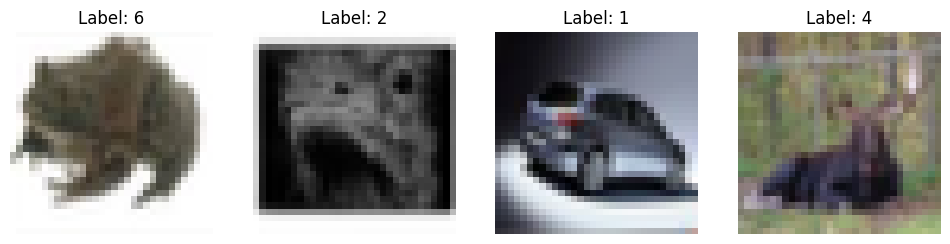

Enter a model name from torchvision:  resnet18


Successfully loaded resnet18 model.
Model resnet18 is ready to be used.


Enter the number of epochs:  32
Enter the learning rate:  .1
Enter patience for early stopping:  10
Enter minimum delta for improvement:  10
Enable verbose output? (yes/no):  yes


Using device: cuda


Epoch 1/32, Validation Loss: 1.9796


Epoch 2/32, Validation Loss: 66.5601


Epoch 3/32, Validation Loss: 17.9403


Epoch 4/32, Validation Loss: 16.8515


Epoch 5/32, Validation Loss: 2.4782


Epoch 6/32, Validation Loss: 2.4574


Epoch 7/32, Validation Loss: 2.4784


Epoch 8/32, Validation Loss: 2.4275


Epoch 9/32, Validation Loss: 3.6234


Epoch 10/32, Validation Loss: 9.2963


Epoch 11/32, Validation Loss: 5.2612
Early stopping at epoch 11


Test Loss: 5.2639, Test Accuracy: 10.00%


In [28]:
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.data
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch
import difflib
import inspect
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Dynamically get a list of all available datasets in torchvision
def get_available_datasets():
    dataset_classes = []
    for name, obj in inspect.getmembers(datasets):
        if inspect.isclass(obj) and issubclass(obj, torch.utils.data.Dataset):
            dataset_classes.append(name)
    return dataset_classes

# Dynamically get a list of all available models in torchvision
def get_available_models():
    model_classes = []
    for name, obj in inspect.getmembers(models):
        if inspect.isfunction(obj):
            model_classes.append(name)
    return model_classes

available_datasets = get_available_datasets()
available_models = get_available_models()

# Define a set of transformations, including converting images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Function to get dataset with robust error handling
def get_dataset(dataset_name, root='./data', batch_size=4, shuffle=True, num_workers=2, train=True):
    try:
        if dataset_name in available_datasets:
            dataset_class = getattr(datasets, dataset_name)
            dataset_instance = dataset_class(root=root, download=True, train=train, transform=transform)
            data_loader = torch.utils.data.DataLoader(dataset_instance, 
                                                      batch_size=batch_size, 
                                                      shuffle=shuffle, 
                                                      num_workers=num_workers)
            print(f"Successfully loaded {dataset_name} {'train' if train else 'test'} dataset.")
            return data_loader
        else:
            close_matches = difflib.get_close_matches(dataset_name, available_datasets, n=3)
            if close_matches:
                print(f"Dataset '{dataset_name}' not found. Did you mean one of these?")
                for match in close_matches:
                    print(f"  - {match}")
                selected_suggestion = input(f"Would you like to load the dataset '{close_matches[0]}'? (yes/no): ").lower()
                if selected_suggestion == 'yes':
                    return get_dataset(close_matches[0], root, batch_size, shuffle, num_workers, train)
            else:
                print(f"Dataset '{dataset_name}' not found. No close matches available.")
    except Exception as e:
        print(f"Error loading dataset: {e}")
    return None

# Function to get model with robust error handling
def get_model(model_name, pretrained=True):
    try:
        if model_name in available_models:
            model_class = getattr(models, model_name)
            model_instance = model_class(pretrained=pretrained)
            print(f"Successfully loaded {model_name} model.")
            return model_instance
        else:
            close_matches = difflib.get_close_matches(model_name, available_models, n=3)
            if close_matches:
                print(f"Model '{model_name}' not found. Did you mean one of these?")
                for match in close_matches:
                    print(f"  - {match}")
                selected_suggestion = input(f"Would you like to load the model '{close_matches[0]}'? (yes/no): ").lower()
                if selected_suggestion == 'yes':
                    return get_model(close_matches[0], pretrained)
            else:
                print(f"Model '{model_name}' not found. No close matches available.")
    except Exception as e:
        print(f"Error loading model: {e}")
    return None

# Early stopping function
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, patience, min_delta, verbose=False):
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)
    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        epoch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for inputs, labels in epoch_iterator:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_iterator.set_postfix({'train_loss': running_loss / (epoch_iterator.n + 1)})

        # Evaluate on validation set
        val_loss = evaluate_model(model, val_loader, criterion, device, return_loss=True)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Evaluation function
def evaluate_model(model, test_loader, criterion, device, return_loss=False):
    model = model.to(device)
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = correct / total * 100
    if return_loss:
        return avg_loss
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# Function to display a grid of images from the dataset
def show_images(images, labels):
    try:
        images = images.numpy()
        fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
        for i, (image, label) in enumerate(zip(images, labels)):
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            axes[i].imshow(image)
            axes[i].set_title(f"Label: {label}")
            axes[i].axis('off')
        plt.show()
    except Exception as e:
        print(f"Error displaying images: {e}")

# Main function to select dataset, model, and train
def main():
    try:
        user_input_dataset = input("Enter a dataset name from torchvision: ")
        batch_size = int(input("Enter batch size: "))
        
        train_loader = get_dataset(user_input_dataset, batch_size=batch_size, train=True)
        test_loader = get_dataset(user_input_dataset, batch_size=batch_size, train=False)

        if train_loader:
            for images, labels in train_loader:
                print(f"Loaded a batch of size: {len(images)}")
                show_images(images[:4], labels[:4])
                break
    
        user_input_model = input("Enter a model name from torchvision: ")
        model = get_model(user_input_model)

        if model:
            print(f"Model {user_input_model} is ready to be used.")

        epochs = int(input("Enter the number of epochs: "))
        learning_rate = float(input("Enter the learning rate: "))
        patience = int(input("Enter patience for early stopping: "))
        min_delta = float(input("Enter minimum delta for improvement: "))
        verbose = input("Enable verbose output? (yes/no): ").lower() == 'yes'

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Split the test set for validation (you can also create a validation set if needed)
        val_loader = test_loader

        # Train the model with early stopping
        train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, patience, min_delta, verbose)

        # Final evaluation
        evaluate_model(model, test_loader, criterion, device)
    
    except ValueError as ve:
        print(f"Input Error: {ve}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Run the main function
if __name__ == '__main__':
    main()
